<a href="https://colab.research.google.com/github/ttopejohnson-blip/Mobile-Game-Analysis/blob/main/Copy_of_Thesis_'Mobile_Game_In_App_Purchases_%E2%80%93_Predicting_Signs_of_High_Spending_in_Users'.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, I will import the 2025 Mobile Game In-App Purchases dataset and will need to do an initial inspection to make sure the missing values won't affect the data analysis.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
uploaded = files.upload()

# Loading the dataset
df = pd.read_csv('mobile_game_inapp_purchases.csv')

# Initial inspection to identify null values and data types
print("Data Profile:")
print(df.info())
print(df.describe())



Saving mobile_game_inapp_purchases.csv to mobile_game_inapp_purchases (1).csv
Data Profile:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   UserID                         3024 non-null   object 
 1   Age                            2964 non-null   float64
 2   Gender                         2964 non-null   object 
 3   Country                        2964 non-null   object 
 4   Device                         2964 non-null   object 
 5   GameGenre                      2964 non-null   object 
 6   SessionCount                   3024 non-null   int64  
 7   AverageSessionLength           3024 non-null   float64
 8   SpendingSegment                3024 non-null   object 
 9   InAppPurchaseAmount            2888 non-null   float64
 10  FirstPurchaseDaysAfterInstall  2888 non-null   float64
 11  PaymentMethod   

Since non-spenders often have blank values in this dataset, I am filling missing InAppPurchaseAmount values with 0. Additionally, I am creating a HasPurchasedFlag. Because a missing LastPurchaseDate is a signal of a non-converter rather than a data error, this binary flag allows the model to capture that behavioral distinction.

In [ ]:
# 1. Numerical Imputation: Fill missing Age with the Median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Categorical Imputation: Handling Gender, Country, Genre, and Payment
# Using 'Unknown' to preserve rows for rare 'whale' users
null_columns = ['Gender', 'Country', 'GameGenre', 'PaymentMethod']
for col in null_columns:
    df[col] = df[col].fillna('Unknown')

# Imputation: Non-spenders often have blank purchase values in the dataset
df['InAppPurchaseAmount'] = df['InAppPurchaseAmount'].fillna(0)

# Temporal Flagging: Validating empty LastPurchaseDate entries
# Users with no date (NaN) are flagged as 0 (non-converters)
df['HasPurchasedFlag'] = np.where(df['LastPurchaseDate'].isnull(), 0, 1)

I am now implementing feature engineering to capture engagement depth through cumulative (TotalPlayTime) and normalized (TimePerSession) metrics.

In [ ]:
# Create Cumulative and Normalized features
df['TotalPlayTime'] = df['SessionCount'] * df['AverageSessionLength']
df['TimePerSession'] = df['TotalPlayTime'] / (df['SessionCount'] + 0.1)

print(df[['SessionCount', 'AverageSessionLength', 'TotalPlayTime', 'TimePerSession']].head())

   SessionCount  AverageSessionLength  TotalPlayTime  TimePerSession
0             9                 12.83         115.47       12.689011
1            11                 19.39         213.29       19.215315
2             9                  8.87          79.83        8.772527
3            12                 19.56         234.72       19.398347
4            10                 15.23         152.30       15.079208


I am visualizing the player age distribution to validate my imputation strategy. This ensures that using the median to fill missing values did not create an unrealistic "spike" or distortion in the data that could bias the future model. This step serves as a "grounded signal" check before moving into advanced behavioral analysis.

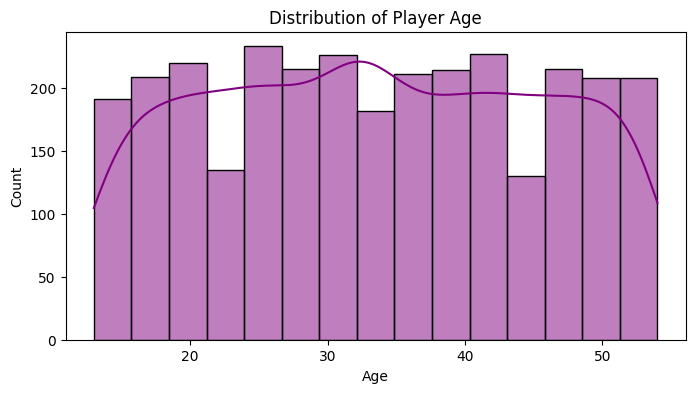

In [ ]:
#  Visualizing player age distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], kde=True, color='purple')
plt.title('Distribution of Player Age')
plt.savefig('age_distribution.png')
plt.show()

I am visualizing the player age distribution and comparing SessionCount across segments to validate the "Habit" construct—the idea that "Whales" demonstrate higher engagement density.

/tmp/ipython-input-1711220761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SpendingSegment', y='SessionCount', data=df, palette='magma')


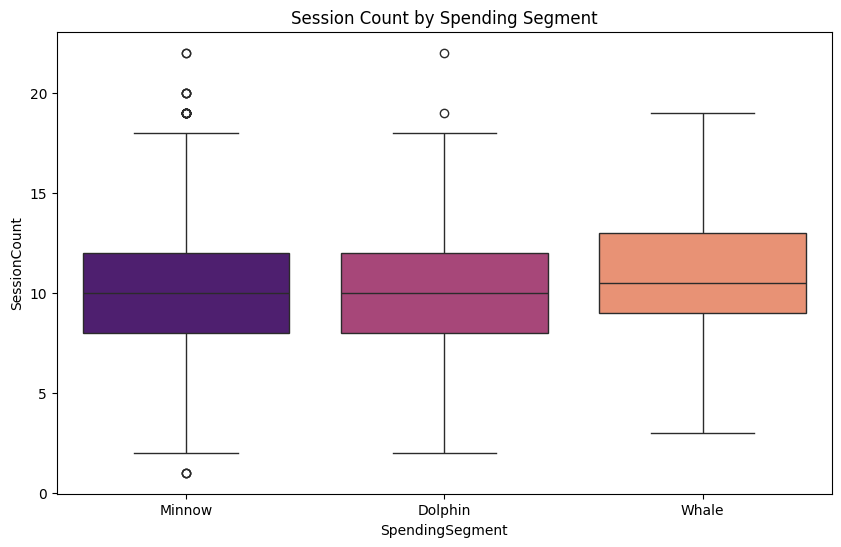

In [ ]:
# Visualizing Session Density by Spending Tier
plt.figure(figsize=(10, 6))
sns.boxplot(x='SpendingSegment', y='SessionCount', data=df, palette='magma')
plt.title('Session Count by Spending Segment')
plt.show()

I am generating a correlation heatmap. This identifies which features have the strongest relationship with spending and ensures that the engineered features I plan for next week (like TotalPlayTime) are grounded in significant data signals.

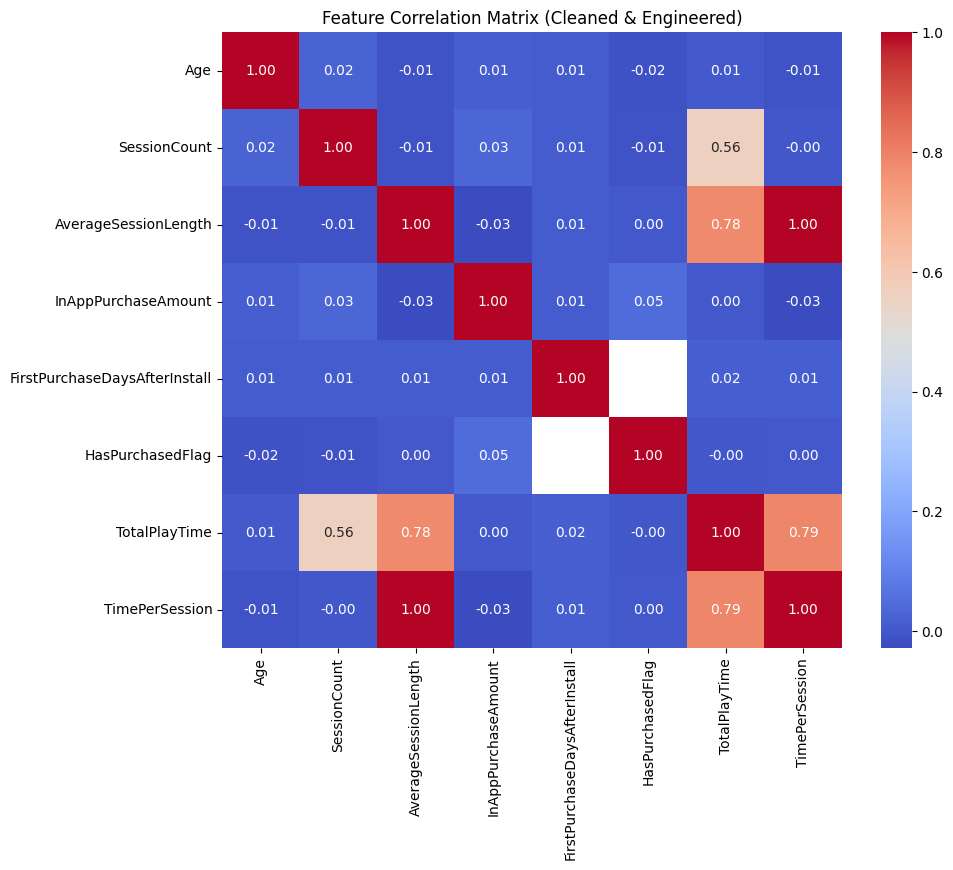

In [ ]:
# Updated Correlation Matrix including new features
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix (Cleaned & Engineered)')
plt.show()

I am implementing a preprocessing pipeline. This transforms categorical data into a machine-readable format and scales numerical features so that high-value variables (like TotalPlayTime) do not unfairly bias the model compared to smaller variables (like Age).

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Encoding Categorical Variables
# One-Hot Encoding for small categories
df = pd.get_dummies(df, columns=['Gender', 'Device', 'GameGenre'], drop_first=True)

# Label Encoding for high-variety categories (Country and PaymentMethod)
le = LabelEncoder()
df['Country_Encoded'] = le.fit_transform(df['Country'].astype(str))
df['Payment_Encoded'] = le.fit_transform(df['PaymentMethod'].astype(str))

# 2. Scaling Numerical Features
scaler = StandardScaler()
scale_cols = ['Age', 'SessionCount', 'AverageSessionLength', 'TotalPlayTime', 'TimePerSession']
df[scale_cols] = scaler.fit_transform(df[scale_cols])

print("Preprocessing complete. Data is now scaled and encoded for baseline modeling.")

Preprocessing complete. Data is now scaled and encoded for baseline modeling.
